In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import cv2
import time
import random
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math
import rospy
from scipy.spatial.transform import Rotation as R
import torchvision.models as models
import itertools
import torchvision.transforms as T
import os

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class ModResNet2(nn.Module):
    def __init__(self, in_chans, out):
        super(ModResNet2, self).__init__()
        original_model = models.resnet101(pretrained=True)
        original_model.conv1 = nn.Conv2d(
                    in_channels=in_chans, 
                    out_channels=original_model.conv1.out_channels,
                    kernel_size=original_model.conv1.kernel_size,
                    stride=original_model.conv1.stride,
                    padding=original_model.conv1.padding,
                    bias=original_model.conv1.bias)
        
        self.features = nn.Sequential(
            original_model.conv1,
            original_model.bn1,
            original_model.relu,
            original_model.maxpool,
            original_model.layer1,
            original_model.layer2,
            original_model.layer3,
            original_model.layer4
        )
        self.avgpool = original_model.avgpool
        
        num_features = original_model.fc.in_features
        num_out_feas = out
        original_model.fc = nn.Linear(num_features, num_out_feas)
        self.fc = original_model.fc  
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        out_fc = self.fc(x)
        return out_fc

In [4]:
class PoseTransformer(nn.Module):
    def __init__(self, num_layers=3, embed_dim=256, num_heads=8, ff_dim=512, 
                 dropout=0.1, out_dim=24):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, 361, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc1 = nn.Linear(embed_dim, out_dim)
        self.embed_dim = embed_dim

    def forward(self, x):
        B = x.shape[0]
        x = x.view(B, self.embed_dim, -1).permute(0, 2, 1)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.fc1(x)
        return x

In [5]:
class align_net(nn.Module):
    def __init__(self):
        super(align_net, self).__init__()
        self.model = ModResNet2(3,512)
        self.lin4d = PoseTransformer(embed_dim=512, num_layers=2, out_dim=3)
        self.lin4c = PoseTransformer(embed_dim=512, num_layers=2, out_dim=3)
    def forward(self, rgb):
        feask = self.model(rgb)
        p_t = self.lin4d(feask)
        p_r = self.lin4c(feask)
        return p_t, p_r

In [6]:
class feedback_net(nn.Module):
    def __init__(self):
        super(feedback_net, self).__init__()
        self.model = ModResNet2(3,512)
        self.lin4c = PoseTransformer(embed_dim=512, out_dim=1, num_layers=4) 
    def forward(self, rgb):
        feas_c = self.model(rgb.float().to(device))
        pred_score = self.lin4c(feas_c)
        return pred_score

In [20]:
mod1 = align_net() ##Alignment network
mod1.load_state_dict(torch.load('./align_net.pth'))
mod1 = mod1.eval().to(device)
mod2 = feedback_net()
mod2.load_state_dict(torch.load('./feedback_net.pth'))
mod2 = mod2.eval().to(device)

/home/thomas/anaconda3/envs/yolov8/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/thomas/anaconda3/envs/yolov8/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
## Calibrated parameters for UIUC smart bridge is given here
K_base = np.array([[508.3997, 0, 316.0652],[0,677.8663,254.0068],[0, 0, 1]])
T_base = np.array([34.92314323, 11.66695466,  1.25144778])
R_base = np.array([[-0.22990146,  0.97289404, -0.02495011],
       [-0.28855094, -0.09262579, -0.95297367],
       [-0.92945343, -0.21189066,  0.30202429]])

In [ ]:
#TODO
# Load the surrogate model, repoject, visualize and validate geometric accuracy and correctness of initial params.
img_base = cv2.imread('./INAF/codes/img149.png')
def gen_geom_smb():
    file_path = './smb_3dcoords.txt'
    vertices = np.loadtxt(file_path)
    return vertices
XYZ = gen_geom_smb()

In [23]:
#TODO
## set the resolution of your baseline image(s) here
U2, V2 = np.meshgrid(np.arange(0,640), np.arange(0, 480))
U2, V2 = U2.flatten(), V2.flatten()
UV2 = np.vstack((U2, V2)).T
UV21 = np.hstack((UV2, np.ones((len(UV2),1))))

In [ ]:
#TODO
#load the depth map for the baseline image(s)
dimg_base_ = np.load('./INAF/codes/dept_temp_0.npy')
hd,wd = dimg_base_.shape[0:2]
# If depth map is not aligned with the image, i.e., different K-matrix, allign here:
Z1 = dimg_base_.flatten()
K1 = np.array([385.477716, 0.0, 320, 0.0, 385.477716, 240, 0.0, 0.0, 1.0]).reshape(3,3)
Z2U2 = K_base@(np.linalg.inv(K1))@(Z1*UV21.T)
dimg_base = Z2U2[-1,:].reshape(hd,wd)

In [12]:
def init_pose(img1_rgb, img2_rgb, dimg1, K1, R1, T1, max_matches=50):
    ###Feature matching to initialize query image pose
    
    img1_gray = cv2.cvtColor(img1_rgb, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2_rgb, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create(nfeatures=1000)
    kp1, des1 = orb.detectAndCompute(img1_gray, None)
    kp2, des2 = orb.detectAndCompute(img2_gray, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    matches = matches[:max_matches]
    uv1 = np.array([kp1[m.queryIdx].pt for m in matches])
    uv2 = np.array([kp2[m.trainIdx].pt for m in matches])
    u1,v1 = np.floor(uv1[:,0]+0.5).astype(np.int16), np.floor(uv1[:,1]+0.5).astype(np.int16)
    z1 = dimg1[v1,u1,0]
    ind1 = z1>0.0
    z1_v = z1[ind1]
    uv1_v = uv1[ind1,:]
    uv2_v = uv2[ind1,:]

    T1 = np.array(T1).reshape(-1,1)
    uv1_v1 = np.hstack((uv1_v,np.ones((len(uv1_v),1))))
    xyz1 = (np.linalg.inv(K1@R1)@(z1_v*uv1_v1.T) + T1).T
    
    xyz = xyz1.astype(np.float32)
    uv = uv2_v.astype(np.float32)
    dist_coeffs = np.zeros((4, 1), dtype=np.float32)
    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        objectPoints=xyz,
        imagePoints=uv,
        cameraMatrix=K1,
        distCoeffs=dist_coeffs,
        flags=cv2.SOLVEPNP_ITERATIVE,
        reprojectionError=8,
        confidence=0.99,
        iterationsCount=100
    )

    if not success:
        raise RuntimeError("PnP failed to find a solution.")

    Rv, _ = cv2.Rodrigues(rvec)
    Tv = (-Rv.T@tvec).flatten()
    return Tv, Rv

In [ ]:
# pts = np.array([[61,306],[68,170],[575,156],[587,297]]) ## 2
# pts = np.array([[100,310],[94,168],[616,66],[637,217]]) ## 3
# pts = np.array([[49,261],[60,113],[598,125],[605,274]]) ## 4
# pts = np.array([[75,252],[78,104],[636,55],[638,213]]) ## 5
# pts = np.array([[3,201],[4,39],[564,61],[568,216]]) ## 6
# pts = np.array([[4,212],[5,52],[527,145],[518,300]]) ## 7
# pts = np.array([[5,31],[595,75],[596,251],[4,199]]) ## 13
# pts = np.array([[4,204],[4,43],[581,91],[587,257]]) ## 14
# pts = np.array([[0,143],[30,3],[108,4],[638,103],[622,286]]) ## 19
# pts = np.array([[4,417],[3,345],[29,270],[592,288],[604,471]]) ## 21
# pts = np.array([[68,377],[95,240],[639,181],[638,362]]) ## 22
# pts = np.array([[9,189],[18,59],[512,23],[500,192]]) ## 31
# pts = np.array([[49,158],[62,34],[556,4],[538,175]]) ## 32
# pts = np.array([[95,479],[101,355],[545,214],[569,368]]) ## 45
# pts = np.array([[164,430],[177,313],[635,278],[636,430]]) ## 48
# pts = np.array([[3,342],[4,203],[458,126],[469,251]]) ## 52
# pts = np.array([[25,209],[39,73],[535,91],[527,235]]) ## 54
# pts = np.array([[143,192],[547,88],[551,240],[143,303]]) ## 170
# pts = np.array([[7,45],[639,134],[639,288],[5,262]]) ## 90
# pts = np.array([[27,255],[638,175],[638,371],[5,440]]) ## 80
# pts = np.array([[3,181],[362,130],[374,229],[7,295]]) ## 146
# pts = np.array([[116,203],[457,101],[470,212],[126,299]]) ## 155
# pts = np.array([[3,7],[539,9],[536,175],[3,173]]) ## 10
# pts = np.array([[140,295],[542,213],[556,357],[139,408]]) ## 171
# pts = np.array([[0,0],[520,22],[514,183],[5,126]]) ## 12
# pts = np.array([[5,27],[600,75],[601,249],[3,188]]) ## 13
# pts = np.array([[4,45],[590,92],[595,261],[4,209]]) ## 14
# pts = np.array([[5,104],[583,25],[604,199],[3,270]]) ## 17
# pts = np.array([[4,204],[500,229],[516,394],[3,373]]) ## 18
# pts = np.array([[142,3],[638,22],[636,212],[120,119]]) ## 20
# pts = np.array([[254,410],[263,301],[638,235],[634,407]]) ## 40
# pts = np.array([[26,273],[599,292],[610,474],[4,416]]) ## 21
# pts = np.array([[0,0],[445,3],[430,114],[4,38]]) ## 25
# pts = np.array([[4,3],[299,5],[426,49],[383,196],[4,57]]) ## 28
# pts = np.array([[5,96],[457,91],[443,251],[4,229]]) ## 30
# pts = np.array([[0,0],[477,0],[444,170],[0,101]]) ## 33
# pts = np.array([[4,243],[445,253],[434,420],[4,390]]) ## 35
# pts = np.array([[169,0],[639,3],[639,112],[170,88]]) ## 38
# pts = np.array([[335,27],[429,3],[639,0],[639,104],[323,138]]) ## 39
# pts = np.array([[108,129],[605,56],[620,205],[104,262]]) ## 55
# pts = np.array([[53,177],[608,251],[608,421],[14,313]]) ## 65
# pts = np.array([[3,395],[548,287],[607,417],[383,478],[0,479]]) ## 100
# pts = np.array([[4,49],[375,25],[379,131],[4,171]]) ## 133
# pts = np.array([[5,183],[417,197],[422,305],[5,308]]) ## 129
# pts = np.array([[4,173],[366,213],[369,327],[5,313]]) ## 120
# pts = np.array([[61,3],[468,5],[460,86],[77,88]]) ## 137
# pts = np.array([[14,312],[53,173],[609,247],[603,422]]) ## 65
# pts = np.array([[3,45],[530,144],[517,303],[5,217]]) ## 7
# pts = np.array([[151,305],[147,212],[492,161],[495,271]]) ## 149
# pts = np.array([[3,165],[4,7],[530,9],[536,149]]) ## 190
# pts = np.array([[5,196],[4,32],[539,81],[534,236]]) ## 59

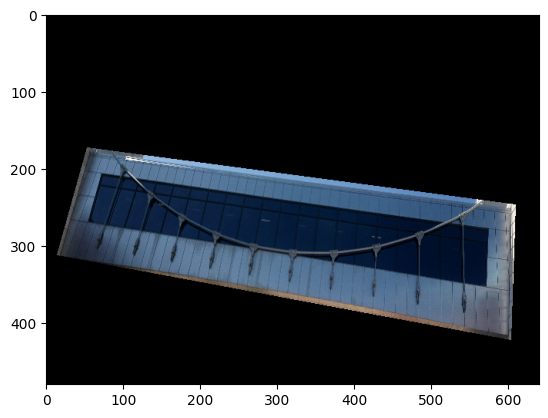

In [ ]:
#TODO
#load the query image, plot the query image and pick coordinates in clockwise manner to isolate the target structure
#Example image-bounding box masks for UIUC Kavita and Lalith Bahl Smart bridge is given below
img_query = cv2.imread('./INAF/codes/img13.png')
pts = np.array([[5,31],[595,75],[596,251],[4,199]]) ## 13

# pts = np.array([[5,183],[417,197],[422,305],[5,308]]) ## 129
# pts = np.array([[14,312],[53,173],[609,247],[603,422]]) ## 65
# pts = np.array([[5,196],[4,32],[539,81],[534,236]]) ## 59
# pts = np.array([[3,165],[4,7],[530,9],[536,149]]) ## 190
# pts = np.array([[61,3],[468,5],[460,86],[77,88]]) ## 137
# pts = np.array([[4,173],[366,213],[369,327],[5,313]]) ## 120
# pts = np.array([[4,49],[375,25],[379,131],[4,171]]) ## 133
# pts = np.array([[3,395],[548,287],[607,417],[383,478],[0,479]]) ## 100
# pts = np.array([[108,129],[605,56],[620,205],[104,262]]) ## 55
# pts = np.array([[335,27],[429,3],[639,0],[639,104],[323,138]]) ## 39
# pts = np.array([[9,189],[18,59],[512,23],[500,192]]) ## 31
# pts = np.array([[49,158],[62,34],[556,4],[538,175]]) ## 32
# pts = np.array([[49,261],[60,113],[598,125],[605,274]]) ## 4
# pts = np.array([[75,252],[78,104],[636,55],[638,213]]) ## 5

msk = np.zeros((480,640),dtype=np.uint8)
cv2.fillPoly(msk, pts[np.newaxis,:,:], 1)
msk = np.stack([msk]*3,-1)
img_q_msk = (msk*img_query).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_q_msk, cv2.COLOR_BGR2RGB))
plt.show() 

In [14]:
def pt_trans(img, ph_trans = False):
    if ph_trans:
        img = torch.tensor(img)/255
        img = T.ToPILImage()(img)
        photometric_transforms = T.ColorJitter(
            brightness=0.5,
            contrast=0.5
        )
        img = photometric_transforms(img)
        img = T.ToTensor()(img)
        img = 255*img.squeeze(0).numpy()
    return img

In [15]:
def comb_imgs(imgi, T1_, qi, K1, rad=2, sz=300, rev=True, viz=False, ph_trans=False):
    imgi = cv2.cvtColor(imgi, cv2.COLOR_BGR2GRAY)
    imgi = pt_trans(imgi, ph_trans)
    imgi = np.stack([imgi]*3,-1)
    imgi = np.array(imgi).astype(np.uint8)
    if rev:
        ru1 = np.array(R.from_quat([qi[1],qi[2],qi[3],qi[0]]).as_euler('xyz',degrees=True))
    else:
        ru1 = np.array(R.from_quat(qi).as_euler('xyz',degrees=True))
    R1_ = np.array(R.from_euler('xyz', ru1, degrees=True).as_matrix())
    ZUV1 = K1@R1_@(XYZ.T - T1_)
    UV1 = np.round(ZUV1/ZUV1[2:,:]).astype(np.int32)
    U1, V1 = UV1[0,:], UV1[1,:]
    h1, w1 = imgi.shape[0:2]
    ind = (U1>=0)*(U1<w1)*(V1>=0)*(V1<h1)
    U1, V1 = U1[ind], V1[ind]
    blk_img = np.zeros_like(imgi[:,:,0])
    for v, u in zip(V1, U1):
        cv2.circle(blk_img, (u, v), rad, 255, -1)
    msk = blk_img>0
    blk_img[msk] = 255
    imgk = np.array(imgi)
    blk_img = np.stack([blk_img]*3,-1)
    mks2 = np.all(blk_img == [255, 255, 255], axis=-1)
    blk_img[mks2] = [0, 0, 255]
    mcomb = (1-msk[:,:,np.newaxis])*imgk + blk_img
    imgk_tsr = F.interpolate(torch.tensor(mcomb/255.0).permute(2,0,1).unsqueeze(0), size=(sz,sz), mode='bilinear', align_corners=False)
    mcomb_ = cv2.resize(mcomb.astype(np.uint8),(sz,sz),interpolation=cv2.INTER_LINEAR)
    return imgk_tsr.squeeze(0).float(), mcomb_

In [ ]:
def group_pred(modn, K1, T1_, R_g_c1_, imgi, pred_dt, pred_dr, sig_pos, sig_rot, N=50):
    samp_dt = np.vstack((pred_dt, np.random.normal(loc=pred_dt, scale=sig_pos, size=(N, 3))))
    samp_dr = np.vstack((pred_dr, np.random.normal(loc=pred_dr, scale=sig_rot, size=(N, 3))))
    a_scores = []
    pT, pR = [], []
    next_viz, nxt_tsr = [], []
    for i in range(samp_dt.shape[0]):
        s_dt = samp_dt[i,:]
        s_dr = samp_dr[i,:]
        pR_c2_c1 = np.array(R.from_euler('xyz',s_dr,degrees=True).as_matrix())
        pR_g_c1 = pR_c2_c1@R_g_c1_
        pT1 = T1_.reshape(-1,1) - s_dt.reshape(-1,1)
        pT.append(pT1), pR.append(pR_g_c1)
        p_qi_ = R.from_matrix(pR_g_c1).as_quat()
        img_tsr, img_viz = comb_imgs(imgi, pT1, p_qi_, K1, rev=False)
        nxt_tsr.append(img_tsr)
        next_viz.append(img_viz)
        pscore = modn(img_tsr.unsqueeze(0).float().to(device))
        pscore = torch.sigmoid(pscore).flatten().cpu().item() #
        a_scores.append(pscore)
    score = np.max(a_scores)
    print("bs_scr: ", score)
    bind = np.argmax(a_scores)
    return score, pT[bind], pR[bind], next_viz[bind], nxt_tsr[bind]

In [17]:
##Transformation from camera to body frame in Blender/Gazebo
roll_c_u, pitch_c_u, yaw_c_u = -(3.141592/2), 0, 3.141592/2 #r_xr, r_yr, r_zr#  
rx = np.matrix([[1, 0, 0],[0, math.cos(roll_c_u),-math.sin(roll_c_u)], [0, math.sin(roll_c_u), math.cos(roll_c_u)]])
ry = np.matrix([[math.cos(pitch_c_u), 0, math.sin(pitch_c_u)],[0, 1, 0],[-math.sin(pitch_c_u), 0, math.cos(pitch_c_u)]])
rz = np.matrix([[math.cos(yaw_c_u), -math.sin(yaw_c_u), 0],[math.sin(yaw_c_u), math.cos(yaw_c_u), 0],[0, 0, 1]])
R_c_b = np.matmul(np.matmul(rz,ry),rx)

In [ ]:
def INAF(moda, modf, img_q, K_base, niters=15, Ng=50, viz=False, Ntop=3, amn=-10.0,amx=10.0,tmin=-0.7, tmax=0.7):
    mod = moda.eval()
    modn = modf.eval()
    clear_output(wait=True)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.5
    font_scale2 = 1.5
    font_scale3 = 0.9
    color = (0, 255, 0)
    thickness = 2
    thickness2 = 2
    pos1 = (10, 28)
    pos1b = (10, 70)
    pos1c = (10, 120)
    pos2 = (50, 440)
    start_time = time.time()
    with torch.no_grad():
        try:
            dt = np.random.uniform(0.0,0.0,3)
            dr = np.random.uniform(0.0,0.0,3) 
            T_init, R_init = init_pose(img_base, img_query, dimg_base, K_base, R_base, T_base)
        except:
            dt = np.random.uniform(tmin,tmax,3)
            dr = np.random.uniform(amn,amx,3)
            T_init, R_init = T_base, R_base
            T_init = T_base + dt      
        
        T2 = T_init
        ru1 = R.from_matrix(R_init).as_euler('xyz',degrees=True)
        qi2 = np.array(R.from_euler('xyz', ru1+dr, degrees=True).as_quat())
        qi2 = (qi2/np.linalg.norm(qi2)).tolist()
        R_g_c2 = np.array(R.from_quat(qi2).as_matrix())
        T1_ = T2.reshape(-1,1)
        R_g_c1_ = R_g_c1 = R_g_c2
        img_tsr, img_comb0 = comb_imgs(img_q, T1_, qi2, K_base, rev=False)
        pred_out = mod(img_tsr.unsqueeze(0).float().to(device))
        pt_c2_c1 = pred_out[-1].cpu().numpy().flatten()
        pr_c2_c1 = pred_out[0].cpu().numpy().flatten()

        #TODO
        #Specify the standard deviation for guassiann sampling
        sig_pos = 0.3*np.ones(3)
        sig_rot = 1.5*np.ones(3)
        scores = []
        all_pT, all_pR = [], []
        all_imgs = []
        b_iters = []
        for j in range(niters):
            print("iteration count: ", j+1)
            out_j = group_pred(modn, K1, T1_, R_g_c1_, img_q, pt_c2_c1, pr_c2_c1, sig_pos, sig_rot, N=Ng)
            score, T1_, R_g_c1_, img_viz, img_tsr = out_j
            pred_out = mod(img_tsr.unsqueeze(0).float().to(device))
            pt_c2_c1 = pred_out[-1].cpu().numpy().flatten()
            pr_c2_c1 = pred_out[0].cpu().numpy().flatten()
            scores.append(score)
            all_pT.append(T1_.flatten()), all_pR.append(R_g_c1_), b_iters.append(j)
            all_imgs.append(img_viz)
        
        end_time = time.time()
        t_time = end_time - start_time
        b_ind = np.argsort(scores)[-Ntop:][::-1] #[-1]#[:Ntop]#
        o_bind = np.argsort(scores)[-1]
        trans_bi = np.round(T2.flatten(),2).tolist()
        R2 = R.from_euler('xyz',ru1+dr,degrees=True).as_matrix()
        rot_bi = np.round(R.from_matrix(R2.T@R_c_b.T).as_euler('xyz',degrees=True),2).tolist() #rotation in camera body frame
        cv2.putText(img_comb0, 'Time = '+str(round(t_time,2))+' sec.', pos1, font, font_scale3, color, thickness2)
        cv2.putText(img_comb0, 'T = '+str(trans_bi), pos1b, font, font_scale3, color, thickness2)
        cv2.putText(img_comb0, 'r = '+str(rot_bi), pos1c, font, font_scale3, color, thickness2)
        cv2.putText(img_comb0, 'Initial ', pos2, font, font_scale2, color, thickness2)   
        fimgs_dips = [img_comb0]

        best_T, best_R = [], []
        for bi in b_ind:
            trans_bi = np.round(all_pT[bi],2).tolist()
            rot_bi = np.round(R.from_matrix(all_pR[bi]@R_c_b.T).as_euler('xyz',degrees=True),2).tolist()
            best_T.append(all_pT[bi])
            best_R.append(all_pR[bi])
            fp_img  = all_imgs[bi].astype(np.uint8)
            itr = b_iters[bi]
            cv2.putText(fp_img, 'score = '+str(round(100*scores[bi],2))+'%', pos1, font, font_scale3, color, thickness)
            cv2.putText(fp_img, 'T = '+str(trans_bi), pos1b, font, font_scale3, color, thickness2)
            cv2.putText(fp_img, 'r = '+str(rot_bi), pos1c, font, font_scale3, color, thickness2)
            cv2.putText(fp_img, '@ iteration '+str(itr+1), pos2, font, font_scale2, color, thickness2)
            fimgs_dips.append(fp_img)

        if viz:
            all_imgs = cv2.cvtColor(np.hstack(fimgs_dips), cv2.COLOR_RGB2BGR)
            plt.figure(figsize=(50, 10))
            plt.imshow(all_imgs)
            plt.show()
    return best_T, best_R

In [ ]:
calib_proposals = INAF(mod1, mod2, img_q_msk, K_base, niters=10, Ng=10, viz=True, Ntop=3)